<img src="https://docs.openmc.org/en/stable/_static/openmc_logo.png" align="left" width=400px />
<br>
<br>
<br>
<br>
<p align="left">
    <h1>Advanced Tallies </h1>
</p>

In [1]:
import openmc
import numpy as np
from matplotlib import pyplot as plt

In this module we'll explore more complicated tallies in OpenMC. 

  - cell and material instance filters
  - tally triggers
  - functional expansion filters


## Cell Instances

During simulation initialization, OpenMC tracks the number of times cells appear in the geometry. This allows tally information to be separated into different bins for each usage or, in OpenMC parlance, "instance", of those cells and materials. Cell instances also allow model properties, like temperature, to vary throughout the model.

The number of instances a cell has can be determined once a `openmc.Geometry` object has been created. Calling `Geometry.determine_paths` will traverse the entire geometry to find all useages of cells in the model. The number of instances for a given well will be populated in the geometry objects themselves (i.e. the `openmc.Cell.num_instances` and `openmc.Cell.paths` properties).

In [2]:
# inner universe
z_cyl = openmc.ZCylinder(r=1.0, boundary_type='vacuum')
inside_cell = openmc.Cell(region=-z_cyl)
outside_cell = openmc.Cell(region=+z_cyl)
cyl_universe = openmc.Universe(cells=[inside_cell, outside_cell])

z_plane = openmc.ZPlane()
cell1 = openmc.Cell(region=-z_plane, fill=cyl_universe)
cell2 = openmc.Cell(region=+z_plane, fill=cyl_universe)
geometry = openmc.Geometry([cell1, cell2])
geometry.determine_paths()
print(f'Cylinder Cell Instances: {inside_cell.num_instances}')
print(f'Cylinder Cell Paths: {inside_cell.paths}')


Cylinder Cell Instances: 2
Cylinder Cell Paths: ['u2->c3->u1->c1', 'u2->c4->u1->c1']


# Instance Filters

The cell and material instance tracking can be leveraged in tallies using the `openmc.DistribCellFilter` and the `openmc.CellInstanceFilter`.

  - `DistribCellFilter`: The bins of this filter are _all_ instances of a given cell.
  - `CellInstanceFilter`: The bins of this filter are cell IDs and instance numbers of the cell. 

### The `CellInstanceFilter`

This filter can be created by passing a list (or other Iterable object) whose entries are tuples containig two items: 

  - first, an `openmc.Cell` object or an integer representing the cell ID and
  - second, the instance of the cell to be included in the tally

**Note that different cells can be specified in the same `CellInstanceFilter`.**

In [3]:
# insert cell into universe/geometry here
cell_instance_filter = openmc.CellInstanceFilter([(inside_cell, 0), (2, 0)])
tally = openmc.Tally()
tally.filters = [cell_instance_filter]

### The `DistribCellFilter`

In many cases, we'd like to separate tally information based on which instance of a cell the particles are for _all_ instances of the cell in the model. Rather than specify every instance value to a `CellInstanceFilter`, we can use the `DistribCellFilter`. 

**Note that this filter only supports one cell at a time.**

In [4]:
cell = openmc.Cell()
# insert cell into universe/geometry here
distribcell_filter = openmc.DistribcellFilter(cell)
tally = openmc.Tally()
tally.filters = [distribcell_filter]

For example, this can be used to find pincell powers for a pin inserted in to an `openmc.Lattice` object. We'll use the `pwr_assembly` model provided in the `openmc.examples` module.

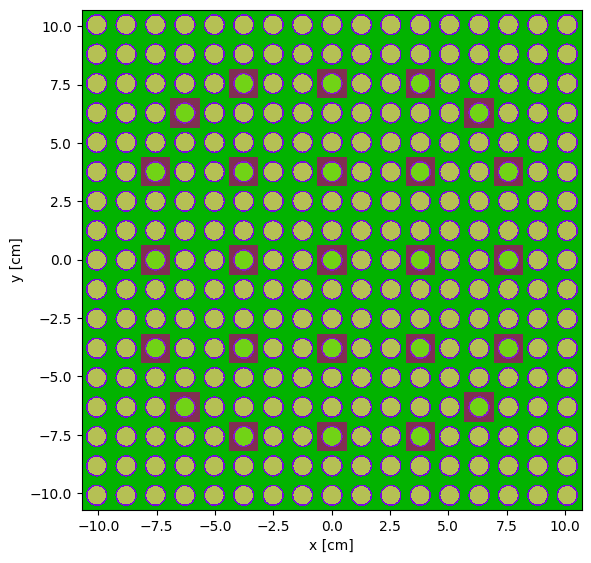

In [5]:
model = openmc.examples.pwr_assembly()
model.geometry.plot(pixels=(500, 500))
plt.show()

First, we'll identify one of the fuel cells on the `openmc.Model` object.


In [6]:
model.materials[0]

for cell in model.geometry.get_all_material_cells().values():
    if cell.fill.name == 'Fuel':
        fuel_cell = cell
        break

print(fuel_cell)


Cell
	ID             =	6
	Name           =	fuel
	Fill           =	Material 1
	Region         =	-3
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None



Now we'll setup a `DistribCellFilter` for this cell in a tally for heating.

In [7]:
tally = openmc.Tally()
tally.filters = [openmc.DistribcellFilter(fuel_cell)]
tally.scores = ['heating']

# tally the total heating as well
total_heat_tally = openmc.Tally()
total_heat_tally.scores = ['heating']

model.tallies += [tally, total_heat_tally]

In [8]:
model.settings.particles = 10_000
model.settings.batches = 50
model.settings.inactive = 10
sp_file = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Assuming a power value of $86.7 \frac{kW}{cm}$ (this is a 2D model) Now we'll extract the heating results and examine them in a pandas dataframe. We'll explore plotting this distribution later.

In [9]:
power = 86700 # W / cm

with openmc.StatePoint(sp_file) as statepoint:
    tally_results = statepoint.tallies[tally.id]
    total_heat_tally_result = statepoint.tallies[total_heat_tally.id]

total_heating = total_heat_tally_result.mean.flat[0]
    
# convert heating from eV/src-particle to W/cm
df = tally_results.get_pandas_dataframe()
df['mean: w/cm'] = power * df['mean'] / total_heating
df['rel. err.'] = df['std. dev.'] / df['mean']
df


level 1      level 2         level 3      distribcell nuclide    score  \
       univ cell     lat            univ cell                                
         id   id      id   x   y      id   id                                
0         6   12       5   0   0       3    6           0   total  heating   
1         6   12       5   1   0       3    6           1   total  heating   
2         6   12       5   2   0       3    6           2   total  heating   
3         6   12       5   3   0       3    6           3   total  heating   
4         6   12       5   4   0       3    6           4   total  heating   
..      ...  ...     ...  ..  ..     ...  ...         ...     ...      ...   
259       6   12       5  12  16       3    6         259   total  heating   
260       6   12       5  13  16       3    6         260   total  heating   
261       6   12       5  14  16       3    6         261   total  heating   
262       6   12       5  15  16       3    6         262   total  heating   
263       6   12       5  16  16       3    6         263   total  heating   

        mean std. dev. mean: w/cm rel. err.  
                                             
                                             
0   2.72e+05  5.51e+03   2.93e+02  2.03e-02  
1   2.70e+05  6.04e+03   2.90e+02  2.24e-02  
2   2.78e+05  6.20e+03   2.99e+02  2.23e-02  
3   2.89e+05  6.99e+03   3.11e+02  2.42e-02  
4   2.78e+05  6.41e+03   2.99e+02  2.30e-02  
..       ...       ...        ...       ...  
259 2.88e+05  5.92e+03   3.10e+02  2.05e-02  
260 2.79e+05  5.83e+03   3.01e+02  2.09e-02  
261 2.73e+05  7.07e+03   2.94e+02  2.59e-02  
262 2.70e+05  5.52e+03   2.90e+02  2.05e-02  
263 2.73e+05  8.54e+03   2.93e+02  3.13e-02  

[264 rows x 14 columns]

## Tally Triggers

Tally triggers are a way of ensuring that OpenMC will only complete a simluation once the tally results have converged to a user-specified limit based on one of: variance, standard deviation, or relative error.

Here, we'll add a trigger to our tally to indicate that OpenMC should not exit until all of our heating values are below 2% relative error. Triggers ensure a pre-specified level of tally data fidelity without needing to guess the number of particles needed to reduce the tally variance to an acceptable level for your analysis.

In [10]:
trigger = openmc.Trigger(trigger_type='rel_err', threshold=0.02)
tally.triggers = [trigger]

Trigger behavior is goverened by the `openmc.Settings` object on the model using 3 properties:

  - `Settings.triggers_active`: whether or not to use triggers to determine an end condition for the simulation
  - `Settings.trigger_batch_interval`: how many batches to run between trigger checks
  - `Settings.trigger_max_batches`: the upper limit on how many batches to run before ending the simulation.

This is an instance where capturing the resulting statepoint file from the `model.run` command is extremely useful as we don't know a priori the number of batches that will run and in turn cannot predict the name of the statepoint file produced.

**Note: In the output below, no trigger conditions are checked until the number of batches by the `model.settings.batches` property has been reached.**

In [11]:
model.settings.trigger_active = True
model.settings.trigger_batch_interval = 5
model.settings.trigger_max_batches = 500
sp_file = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Finally we'll confirm that all of the relative error values for the tally are in fact below the specified threshold.

In [12]:
with openmc.StatePoint(sp_file) as statepoint:
    tally_results = statepoint.tallies[tally.id]

rel_err = tally_results.std_dev / tally_results.mean
print(rel_err.flatten()[:10])
print(all(rel_err < 0.02))

[0.01845209 0.01485676 0.01485105 0.01580283 0.01405037 0.01428377
 0.01412461 0.01510699 0.01250149 0.01596082]
True


## Functional Expansion Tallies (FETs)

While most filters in OpenMC are meant to identify regions of phase space that contribute to a tally, there are a special set of functional expansion filters that will multiply the tally by a set of orthogonal functions, e.g. Legendre polynomials, so that continuous functions of space or angle can be reconstructed from the tallied moments of the function. 

The following set of functional expansion filters are available in OpenMC separated by the basis functions employed:

[Legendre Polynomials](https://en.wikipedia.org/wiki/Legendre_polynomials): Intended for use in representing some linear portion of phase space (e.g. axial distribution of a cell)
 - `openmc.LegendreFilter`: Tally the Legendre moments for changes in angle.
 - `openmc.SpatialLegendreFilter`: Tally the Ledengre moments for a distribution aligned with a global axis.

[Spherical Harmonics](https://en.wikipedia.org/wiki/Spherical_harmonics):
 - `openmc.SphericalHarmonicsFilter`: This filter allows you to obtain real spherical harmonic moments of either the particle’s direction or the cosine of the scattering angle.

[Zernike Polynomials](https://en.wikipedia.org/wiki/Zernike_polynomials): Intended for use in tallying on a cylindrical domain.
 - `openmc.ZernikeFilter`: This filter allows scores to be multiplied by Zernike polynomials of the particle’s position normalized to a given unit circle.
 - `openmc.ZernikeRadialFilter`: Like the `ZernikeFilter`, but only scores on a radial distribution.

As an example, we will determine the spatial dependence of the flux along a pincell axis using a `SpatialLegendreFilter`. This means we will be representing the flux along the z axis, $\phi(z)$ using the functional form:

$$ \phi(z') = \sum\limits_{n=0}^N a_n P_n(z') $$

where $z'$ is the position normalized to the range [-1, 1]. Since $P_n(z)$ are known functions, our only task is to determine the correct expansion coefficients,
$a_n$. 




By the orthogonality properties of the Legendre polynomials, one can deduce that the coefficients, $a_n$, are given by

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z').$$

Thus, the problem reduces to finding the integral of the flux times each Legendre polynomial, $P_n(z`)$ -- a problem which can be solved by using a Monte Carlo tally.

The `SpatialLegendreFilter` allows us to obtain stochastic estimates of the integrals for each polynomial order.

We'll again use the `pwr_pin_cell` model provided by the `openmc.examples` module, but we'll clip the model in the Z dimension to make the axial provile more interesting.

In [13]:
model = openmc.examples.pwr_pin_cell()

# clip all cells in the uppermost universe using two z planes
z_min = openmc.ZPlane(z0=-10.0, boundary_type='vacuum')
z_max = openmc.ZPlane(z0=10.0, boundary_type='vacuum')
for cell in model.geometry.root_universe.get_all_cells().values():
    cell.region &= +z_min & -z_max

print(model.geometry.bounding_box)

BoundingBox(lower_left=(-0.63, -0.63, -10.0), upper_right=(0.63, 0.63, 10.0))


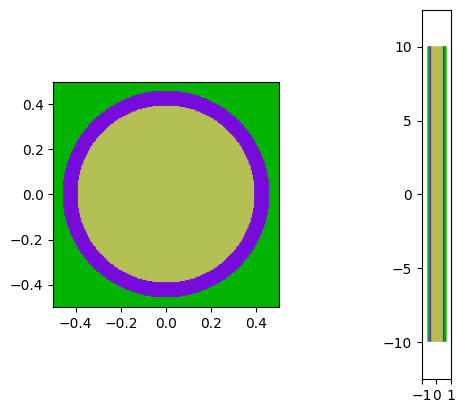

In [14]:
fig, (xy_ax, xz_ax) = plt.subplots(1, 2)
model.geometry.plot(width=(1, 1), basis='xy', axes=xy_ax)
model.geometry.plot(width=(2, 25), basis='xz', axes=xz_ax)
plt.show()

Now we'll apply a `SpatialLegendreFilter` to tally the flux.

In [15]:
tally = openmc.Tally()
legendre_order = 8
spatial_filter = openmc.SpatialLegendreFilter(order=legendre_order,
                                              axis='z',
                                              minimum=-10,
                                              maximum=10)
tally.filters = [spatial_filter]
tally.scores = ['flux']

model.tallies = [tally]

Now we'll adjust settings and run the model.

In [16]:
model.settings.particles = 10_000
model.settings.batches = 50
model.settings.inactive = 10
sp_file = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

And retrieve the tally from the statepoint file and examine it.

In [17]:
with openmc.StatePoint(sp_file) as statepoint:
    tally_results = statepoint.tallies[tally.id]

df = tally_results.get_pandas_dataframe()
df

,spatiallegendre,nuclide,score,mean,std. dev.
0,P0,total,flux,27.834395,0.035052
1,P1,total,flux,-0.029140,0.029309
2,P2,total,flux,-3.764001,0.015331
3,P3,total,flux,0.015813,0.013558
4,P4,total,flux,0.031431,0.008110
5,P5,total,flux,-0.002537,0.005621
6,P6,total,flux,-0.020339,0.005322
7,P7,total,flux,-0.003863,0.005245
8,P8,total,flux,-0.008715,0.004881


## Plotting the FET Data

Recalling that the expansion coefficients are given as

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z').$$

we'll multiply the moments by $\frac{2n + 1}{2}$ to account for this. OpenMC only computes an estimate of the integral.


In [18]:
a_n = df['mean'] * (2*legendre_order+1) / 2

To examine the flux profile, we'll use the `numpy.polynomial.Legendre` class to represent our polynomial series. We'll also perform a change of variables from $z'$ to $z$:

$$ \phi(z) = \frac{\phi(z')}{10} = \sum_{n=0}^N \frac{a_n}{10} P_n(z'). $$

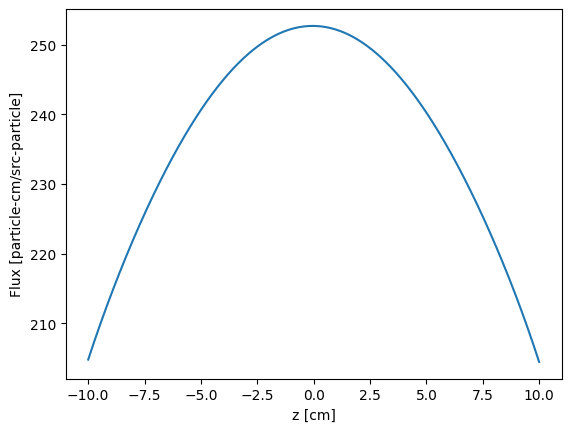

In [19]:
phi = np.polynomial.Legendre(a_n, domain=[-10, 10])
z = np.linspace(-10, 10, 1000)
plt.plot(z, phi(z))
plt.xlabel('z [cm]')
plt.ylabel('Flux [particle-cm/src-particle]')
plt.show()

## Conclusion

This concludes the module on advanced tallies in OpenMC. To recap we've covered:

  - Tallying cell instances
  - Tally triggers
  - Functional expansion tallies

There are a number of filter and score combinations that are not discussed here, but we may cover later in the course.


